# Pneumonia Classification - Chest X-Ray Images

In [1]:
import seaborn as sns
# PyTorch
import torchvision
from torchvision import transforms, datasets, models
import torch
from torch import optim, cuda
from torch.utils.data import DataLoader, sampler
import torch.nn as nn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data science tools
import numpy as np
import pandas as pd
import os

# Image manipulations
from PIL import Image
# Useful for examining n

import matplotlib.pyplot as plt
%matplotlib inline

from skimage import transform
from keras.preprocessing.image import img_to_array,array_to_img

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Get Data

In [2]:
# Mount Drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# Read in data
!unzip "/content/gdrive/My Drive/Hackathon/Classification_Hackathon.zip"

Streaming output truncated to the last 5000 lines.
  inflating: 2. Classification/train/NORMAL/IM-0438-0001.jpeg  
  inflating: 2. Classification/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: 2. Classification/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: 2. Classification/train/NORMAL/IM-0439-0001.jpeg  
  inflating: 2. Classification/train/NORMAL/IM-0440-0001.jpeg  
  inflating: 2. Classification/train/NORMAL/IM-0441-0001.jpeg  
  inflating: 2. Classification/train/NORMAL/IM-0442-0001.jpeg  
  inflating: 2. Classification/train/NORMAL/IM-0444-0001.jpeg  
  inflating: 2. Classification/train/NORMAL/IM-0445-0001.jpeg  
  inflating: 2. Classification/train/NORMAL/IM-0446-0001.jpeg  
  inflating: 2. Classification/train/NORMAL/IM-0447-0001.jpeg  
  inflating: 2. Classification/train/NORMAL/IM-0448-0001.jpeg  
  inflating: 2. Classification/train/NORMAL/IM-0449-0001.jpeg  
  inflating: 2. Classification/train/NORMAL/IM-0450-0001.jpeg  
  inflating: 2. Classification/train/NORMAL

In [36]:
# Unzip test file
!unzip "/content/gdrive/My Drive/Hackathon/Test_Dataset-Classification (1).zip"

Archive:  /content/gdrive/My Drive/Hackathon/Test_Dataset-Classification (1).zip
   creating: test/
   creating: test/NORMAL/
  inflating: test/NORMAL/IM-0001-0001.jpeg  
  inflating: test/NORMAL/IM-0003-0001.jpeg  
  inflating: test/NORMAL/IM-0005-0001.jpeg  
  inflating: test/NORMAL/IM-0006-0001.jpeg  
  inflating: test/NORMAL/IM-0007-0001.jpeg  
  inflating: test/NORMAL/IM-0009-0001.jpeg  
  inflating: test/NORMAL/IM-0010-0001.jpeg  
  inflating: test/NORMAL/IM-0011-0001-0001.jpeg  
  inflating: test/NORMAL/IM-0011-0001-0002.jpeg  
  inflating: test/NORMAL/IM-0011-0001.jpeg  
  inflating: test/NORMAL/IM-0013-0001.jpeg  
  inflating: test/NORMAL/IM-0015-0001.jpeg  
  inflating: test/NORMAL/IM-0016-0001.jpeg  
  inflating: test/NORMAL/IM-0017-0001.jpeg  
  inflating: test/NORMAL/IM-0019-0001.jpeg  
  inflating: test/NORMAL/IM-0021-0001.jpeg  
  inflating: test/NORMAL/IM-0022-0001.jpeg  
  inflating: test/NORMAL/IM-0023-0001.jpeg  
  inflating: test/NORMAL/IM-0025-0001.jpeg  
  inflati

In [37]:
!ls

'2. Classification'   gdrive   sample_data   test


In [5]:
# Change to fit hardware
batch_size = 128

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
multi_gpu = False     

Train on gpu: True
1 gpus detected.


# Create Dataframe to explore images

Text(0.5, 1.0, 'Training Images by Category')

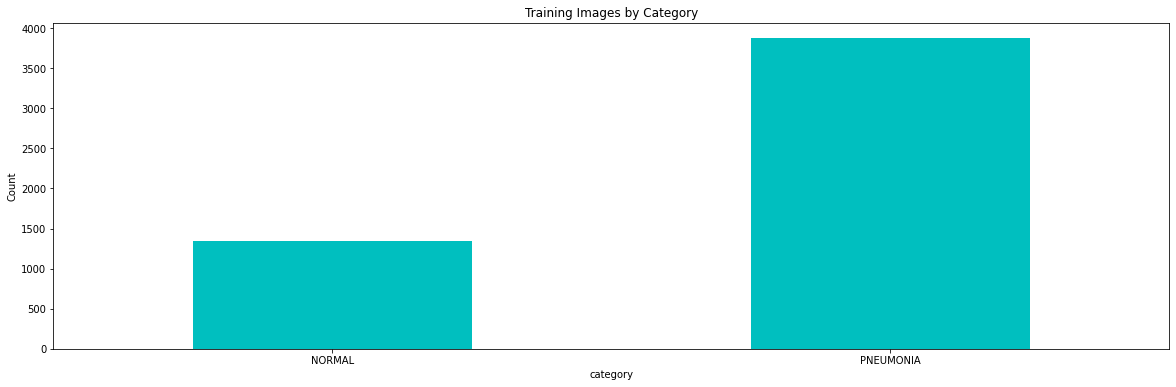

In [7]:
datadir = "/content/2. Classification/"
traindir = datadir + '/train/'
validdir = datadir + '/val/'


# Empty lists
categories = []
img_categories = []
n_train = []
n_valid = []
n_test = []
hs = []
ws = []

# Iterate through each category
for d in os.listdir(traindir):
    if not d.startswith('.'):
        categories.append(d)

        # Number of each image
        train_imgs = os.listdir(traindir + d)
        valid_imgs = os.listdir(validdir + d)
        n_train.append(len(train_imgs))
        n_valid.append(len(valid_imgs))

        # Find stats for train images
        for i in train_imgs:
            if not i.startswith('.'):
                img_categories.append(d)
                img = Image.open(traindir + d + '/' + i)
                img_array = np.array(img)
                # Shape
                hs.append(img_array.shape[0])
                ws.append(img_array.shape[1])

# Dataframe of categories
cat_df = pd.DataFrame({'category': categories,
                       'n_train': n_train,
                       'n_valid': n_valid}).\
    sort_values('category')

# Dataframe of training images
image_df = pd.DataFrame({
    'category': img_categories,
    'height': hs,
    'width': ws
})

#cat_df.sort_values('n_train', ascending=False, inplace=True)
cat_df.set_index('category')['n_train'].plot.bar(
    color='c', figsize=(20, 6))
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.title('Training Images by Category')

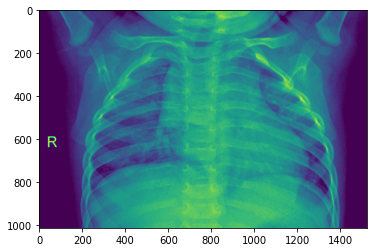

In [8]:
x = Image.open(traindir + 'NORMAL/IM-0128-0001.jpeg')
np.array(x).shape
plt.imshow(x)

In [9]:
cat_df.head()

,category,n_train,n_valid
1,NORMAL,1341,8
0,PNEUMONIA,3875,8


# Build Pytorch DataLoader

In [0]:
testdir = "/content/test"

image_transforms = {
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  
    ]),
  
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),

    'test':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [0]:
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val': datasets.ImageFolder(root=validdir, transform=image_transforms['val']),
    'test': datasets.ImageFolder(root=testdir, transform=image_transforms['val'])
}


dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test':DataLoader(data['test'], batch_size=batch_size, shuffle=True) }

In [12]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([128, 3, 224, 224]), torch.Size([128]))

In [13]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [0]:
for param in model.parameters():
    param.requires_grad = False

In [0]:
n_inputs = model.classifier[6].in_features

# Add on classifier
model.classifier[6] = nn.Sequential(
    nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.4),
    nn.Linear(256, 2), nn.LogSoftmax(dim=1))

model.classifier

model = model.to('cuda')

In [16]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

# Train Network

In [18]:
# Early stopping intialization
epochs_no_improve = 0
valid_loss_min = np.Inf

valid_max_acc = 0
history = []



for epoch in range(5):

    print(epoch)
    running_loss = 0.0


    for i, (data, target) in enumerate(dataloaders['train']):

      data, target = data.cuda(), target.cuda()
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)

      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      if i % 100 == 99:    # print every 2000 mini-batches
          print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
          running_loss = 0.0

print('Finished Training')

0
1
2
3
4
Finished Training


# Predict on train set

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import recall_score

correct = 0
total = 0

with torch.no_grad():
    target_true = np.array([])
    valpredicted_true_pred = np.array([])
    correct_true = np.array([])
    y_pred_list = []
    y_test = []
    for data in dataloaders['train']:
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += float((predicted == labels).sum().item())

        # y_test_pred = torch.sigmoid(outputs.data)
        # y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(predicted.cpu().numpy())
        y_test.append(labels.cpu().numpy())


print('Accuracy of the network: %f %%' % (
    100 * correct / total))


y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_test = [a.squeeze().tolist() for a in y_test]


Accuracy of the network: 91.027607 %


In [29]:
recall_score(y_test[0], y_pred_list[0])

0.92

# Predict on Dev Set

In [30]:
correct = 0
total = 0
with torch.no_grad():
    y_pred_list = []
    y_test = []
    for data in dataloaders['val']:
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += float((predicted == labels).sum().item())
        y_pred_list.append(predicted.cpu().numpy())
        y_test.append(labels.cpu().numpy())

print('Accuracy of the network: %f %%' % (
    100 * correct / total))

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_test = [a.squeeze().tolist() for a in y_test]


Accuracy of the network: 81.250000 %


In [31]:
print(recall_score(y_test[0], y_pred_list[0]))

0.875


# Predict on Test Data

In [51]:
correct = 0
total = 0
with torch.no_grad():
    y_pred_list = []
    y_test = []
    for data in dataloaders['test']:
        inputs, labels = data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += float((predicted == labels).sum().item())
        y_pred_list.append(predicted.cpu().numpy())
        y_test.append(labels.cpu().numpy())

print('Accuracy of the network: %f %%' % (
    100 * correct / total))

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]
y_test = [a.squeeze().tolist() for a in y_test]

print('Recall Score: ',recall_score(y_test[0], y_pred_list[0])*100, '%')

Accuracy of the network: 76.923077 %
Recall Score:  92.13483146067416 %
